## baseline plain

In [ ]:
# bert_baseline_with_full_metrics.py

import math
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix
)
import matplotlib.pyplot as plt
import gc

class ICUTextDataset(Dataset):
    def __init__(self, csv_path, tokenizer_name, max_length, mode='both'):
        self.data = pd.read_csv(csv_path).reset_index(drop=True)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row      = self.data.iloc[idx]
        text     = str(row['text_note'])
        combined = str(row['combined_note'])
        if   self.mode=='text_only':    full_text = text
        elif self.mode=='combined_only': full_text = combined
        else:                           full_text = text + ' ' + combined

        enc = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label':          torch.tensor(row['mortality_label'], dtype=torch.float32)
        }

class BERTClassifier(nn.Module):
    def __init__(self, encoder_name, hidden_dim=768):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:,0,:]
        return self.classifier(cls_emb)

def compute_metrics(probs, labels):
    # determine threshold to match positive rate
    P = int(sum(labels))
    if P > 0:
        thr = sorted(probs, reverse=True)[P-1]
    else:
        thr = 1.0
    preds = [1 if p>=thr else 0 for p in probs]
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        'auc': roc_auc_score(labels, probs),
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'mcc': matthews_corrcoef(labels, preds),
        'specificity': tn/(tn+fp) if (tn+fp)>0 else 0,
        'npv': tn/(tn+fn) if (tn+fn)>0 else 0,
        'threshold': thr
    }

def train_epoch(model, loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    all_probs, all_labels = [], []
    for batch in tqdm(loader, desc="Train", leave=False):
        ids    = batch['input_ids'].to(device)
        mask   = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)
        logits = model(ids, mask)
        loss   = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        probs = torch.sigmoid(logits).cpu().squeeze().tolist()
        all_probs.extend(probs if isinstance(probs, list) else [probs])
        all_labels.extend(labels.cpu().squeeze().tolist())
    metrics = compute_metrics(all_probs, all_labels)
    metrics['loss'] = total_loss/len(loader)
    return metrics

def eval_epoch(model, loader, device, loss_fn):
    model.eval()
    total_loss = 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            ids    = batch['input_ids'].to(device)
            mask   = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            logits = model(ids, mask)
            loss   = loss_fn(logits, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu().squeeze().tolist()
            all_probs.extend(probs if isinstance(probs, list) else [probs])
            all_labels.extend(labels.cpu().squeeze().tolist())
    metrics = compute_metrics(all_probs, all_labels)
    metrics['loss'] = total_loss/len(loader)
    return metrics

def run_experiment(model_name="bert-base-uncased", max_length=512, mode_label="both"):
    ds = ICUTextDataset("final.csv", model_name, max_length, mode_label)
    n  = len(ds)
    train_n = int(0.8*n)
    train_ds, val_ds = random_split(ds, [train_n, n-train_n])
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = BERTClassifier(model_name).to(device)
    train_labels = [ds[i]['label'].item() for i in train_ds.indices]
    neg, pos = train_labels.count(0), train_labels.count(1)
    pos_weight = torch.tensor([(neg/pos) if pos>0 else 1.0], device=device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    epochs = 100
    history = {k: [] for k in ['loss','auc','accuracy','precision','recall','f1','mcc','specificity','npv','threshold']}
    history_val = {k: [] for k in history}

    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        m_tr = train_epoch(model, train_loader, device, loss_fn, optimizer)
        m_val= eval_epoch (model, val_loader,   device, loss_fn)
        for k in history:
            history[k].append(m_tr[k])
            history_val[k].append(m_val[k])
        print(" Train:", {k: f"{m_tr[k]:.4f}" for k in ['loss','auc','accuracy','precision','recall','f1','mcc']})
        print(" Val:  ", {k: f"{m_val[k]:.4f}" for k in ['loss','auc','accuracy','precision','recall','f1','mcc']})

    # Plotting selected metrics
    plt.figure(figsize=(14,10))
    metrics_to_plot = ['loss','auc','accuracy','precision','recall','f1','mcc']
    for i, metric in enumerate(metrics_to_plot,1):
        plt.subplot(3,3,i)
        plt.plot(history[metric], label=f"Train {metric}")
        plt.plot(history_val[metric], label=f"Val   {metric}")
        plt.title(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

    # cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()


run_experiment()





Epoch 1/100


KeyboardInterrupt: 

## base line + keyword

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import re
import numpy as np
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ──── DATASET (TEXT ONLY) ──────────────────────────────────────────────────
class ClinicalNotesDataset(Dataset):
    def __init__(self, csv_path, tokenizer_name, max_length=512, mode='combined'):
        """
        Args:
            mode: 'text' (original note), 'combined' (all notes), or 'discharge' (discharge summary only)
        """
        self.data = pd.read_csv(csv_path)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.mode = mode

        # Clean text during initialization
        self.data['cleaned_text'] = self.data['text_note'].apply(self._clean_text)
        self.data['cleaned_combined'] = self.data['combined_note'].apply(self._clean_text)

    def _clean_text(self, text):
        """Remove clinical note artifacts and truncate intelligently"""
        text = str(text)
        # 1. Remove de-identification markers
        text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
        # 2. Remove multiple newlines and whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # 3. Keep last 2048 characters (prioritize recent info)
        return text[-2048:] if len(text) > 2048 else text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Select text based on mode
        if self.mode == 'text':
            text = row['cleaned_text']
        elif self.mode == 'discharge':
            text = self._extract_discharge_section(row['cleaned_combined'])
        else:  # combined
            text = row['cleaned_combined']

        # Tokenize
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(row['mortality_label'], dtype=torch.float32)
        }

    def _extract_discharge_section(self, text):
        """Extract discharge summary section if available"""
        match = re.search(r'DISCHARGE SUMMARY:(.*?)(?=\n[A-Z]{2,}:|$)', text, re.IGNORECASE|re.DOTALL)
        return match.group(1).strip() if match else text

# ──── MODEL (BERT ONLY) ───────────────────────────────────────────────────
class BERTMortalityPredictor(nn.Module):
    def __init__(self, model_name='emilyalsentzer/Bio_ClinicalBERT', dropout_rate=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        pooled = self.dropout(pooled)
        return self.classifier(pooled)

# ──── TRAINING UTILITIES ──────────────────────────────────────────────────
def train_epoch(model, dataloader, device, optimizer, loss_fn):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        optimizer.zero_grad()

        inputs = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)

        outputs = model(inputs, masks)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, threshold=None):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)

            outputs = model(inputs, masks).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds.extend(probs)
            labels.extend(batch['label'].cpu().numpy())

    # Dynamic thresholding if not specified
    if threshold is None:
        threshold = np.percentile(preds, 100 * (1 - np.mean(labels)))

    bin_preds = (np.array(preds) > threshold).astype(int)

    print(f"\nEvaluation (Threshold={threshold:.3f})")
    print(f"AUC: {roc_auc_score(labels, preds):.4f}")
    print(f"F1: {f1_score(labels, bin_preds):.4f}")
    print(classification_report(labels, bin_preds))
    print("Confusion Matrix:")
    print(confusion_matrix(labels, bin_preds))

    return {
        'auc': roc_auc_score(labels, preds),
        'f1': f1_score(labels, bin_preds),
        'threshold': threshold
    }

# ──── MAIN EXPERIMENT ─────────────────────────────────────────────────────
def run_experiment():
    # Config
    MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"  # Clinical BERT variant
    MAX_LENGTH = 512
    BATCH_SIZE = 16
    EPOCHS = 10
    MODE = 'combined'  # 'text', 'combined', or 'discharge'

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data
    dataset = ClinicalNotesDataset("final.csv", MODEL_NAME, MAX_LENGTH, mode=MODE)

    # Stratified split
    train_idx, val_idx = train_test_split(
        range(len(dataset)),
        test_size=0.2,
        stratify=dataset.data['mortality_label'],
        random_state=42
    )
    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True)

    # Model
    model = BERTMortalityPredictor(MODEL_NAME).to(device)

    # Handle class imbalance
    pos_weight = torch.tensor([
        (len(train_ds) - sum(dataset.data.iloc[train_idx]['mortality_label'])) /
        sum(dataset.data.iloc[train_idx]['mortality_label'])
    ]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Optimizer
    optimizer = torch.optim.AdamW([
        {'params': model.bert.parameters(), 'lr': 2e-5},
        {'params': model.classifier.parameters(), 'lr': 1e-4}
    ], weight_decay=1e-4)

    # Training loop
    best_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Train
        train_loss = train_epoch(model, train_loader, device, optimizer, loss_fn)

        # Evaluate
        val_metrics = evaluate(model, val_loader, device)

        # Save best model
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), f"best_bert_{MODE}.pt")
            print(f"New best model saved (F1={best_f1:.4f})")

if __name__ == "__main__":
    run_experiment()

## Two feature Plain

In [ ]:
# bert_baseline_struct_full_metrics_updated.py

import math
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix
)
import matplotlib.pyplot as plt
import gc

# ─── DATASET WITH STRUCTURED FEATURES ─────────────────────────────────────
class ICUTextStructDataset(Dataset):
    def __init__(self, csv_path, tokenizer_name, max_length, mode='both'):
        df = pd.read_csv(csv_path).reset_index(drop=True)
        # structured columns to include
        self.struct_cols = ['bun','calcium','creatinine','glucose','magnesium','sodium','los']
        # coerce to numeric, fill missing
        df[self.struct_cols] = (
            df[self.struct_cols]
              .apply(pd.to_numeric, errors='coerce')
              .fillna(0.0)
        )
        # standardize structured features
        scaler = StandardScaler()
        df[self.struct_cols] = scaler.fit_transform(df[self.struct_cols])
        self.data = df

        # tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row['text_note'])
        combined = str(row['combined_note'])
        if self.mode == 'text_only':
            full_text = text
        elif self.mode == 'combined_only':
            full_text = combined
        else:
            full_text = text + ' ' + combined

        enc = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        # build structured features list explicitly as floats
        struct_list = [float(row[c]) for c in self.struct_cols]
        struct_feats = torch.tensor(struct_list, dtype=torch.float32)
        label = torch.tensor(row['mortality_label'], dtype=torch.float32)
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'struct_feats':   struct_feats,
            'label':          label
        }

# ─── MODEL WITH STRUCTURED MLP ────────────────────────────────────────────
class BERTWithStruct(nn.Module):
    def __init__(self, encoder_name, struct_dim=7, bert_dim=768):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        # MLP for structured features
        self.struct_mlp = nn.Sequential(
            nn.Linear(struct_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        # fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(bert_dim + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, struct_feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:, 0, :]       # (B, bert_dim)
        struct_emb = self.struct_mlp(struct_feats)     # (B, 32)
        x = torch.cat([cls_emb, struct_emb], dim=1)    # (B, bert_dim + 32)
        return self.classifier(x)                      # (B,1) logits

# ─── METRICS CALCULATION ─────────────────────────────────────────────────
def compute_metrics(probs, labels):
    # calibrate threshold to match positive rate
    P = int(sum(labels))
    thr = sorted(probs, reverse=True)[P-1] if P > 0 else 1.0
    preds = [1 if p>=thr else 0 for p in probs]
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        'auc': roc_auc_score(labels, probs),
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'mcc': matthews_corrcoef(labels, preds),
        'specificity': tn/(tn+fp) if (tn+fp)>0 else 0.0,
        'npv': tn/(tn+fn) if (tn+fn)>0 else 0.0,
        'threshold': thr
    }

# ─── TRAIN & EVAL LOOPS ──────────────────────────────────────────────────
def train_epoch(model, loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    all_probs, all_labels = [], []
    for batch in tqdm(loader, desc="Train", leave=False):
        ids    = batch['input_ids'].to(device)
        mask   = batch['attention_mask'].to(device)
        struct = batch['struct_feats'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)

        logits = model(ids, mask, struct)
        loss   = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        probs = torch.sigmoid(logits).cpu().squeeze().tolist()
        all_probs.extend(probs if isinstance(probs, list) else [probs])
        all_labels.extend(labels.cpu().squeeze().tolist())

    metrics = compute_metrics(all_probs, all_labels)
    metrics['loss'] = total_loss / len(loader)
    return metrics

def eval_epoch(model, loader, device, loss_fn):
    model.eval()
    total_loss = 0.0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            ids    = batch['input_ids'].to(device)
            mask   = batch['attention_mask'].to(device)
            struct = batch['struct_feats'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)

            logits = model(ids, mask, struct)
            loss   = loss_fn(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().squeeze().tolist()
            all_probs.extend(probs if isinstance(probs, list) else [probs])
            all_labels.extend(labels.cpu().squeeze().tolist())

    metrics = compute_metrics(all_probs, all_labels)
    metrics['loss'] = total_loss / len(loader)
    return metrics

def run_experiment(model_name="bert-base-uncased", max_length=512, mode_label="both

    ds = ICUTextStructDataset("final.csv", model_name, max_length, mode_label)
    n = len(ds)
    train_n = int(0.8 * n)
    train_ds, val_ds = random_split(ds, [train_n, n - train_n])
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTWithStruct(model_name).to(device)
    # compute pos_weight for imbalance
    train_labels = [ds[i]['label'].item() for i in train_ds.indices]
    neg, pos = train_labels.count(0), train_labels.count(1)
    pos_weight = torch.tensor([(neg/pos) if pos>0 else 1.0], device=device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    epochs = 100
    keys = ['loss','auc','accuracy','precision','recall','f1','mcc','specificity','
    hist_tr = {k: [] for k in keys}
    hist_val= {k: [] for k in keys}
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        m_tr = train_epoch(model, train_loader, device, loss_fn, optimizer)
        m_val = eval_epoch(model, val_loader, device, loss_fn)
        for k in keys:
            hist_tr[k].append(m_tr[k])
            hist_val[k].append(m_val[k])
        # print full metrics
        summary_tr = {k: f"{m_tr[k]:.4f}" for k in keys}
        summary_val= {k: f"{m_val[k]:.4f}" for k in keys}
        print(" Train:", summary_tr)
        print(" Val: ", summary_val)
        # plotting selected metrics
    plt.figure(figsize=(14,10))
    for i, metric in enumerate(['auc','accuracy','precision','recall','f1','mcc'],
        plt.subplot(3,3,i)
        plt.plot(hist_tr[metric], label="Train")
        plt.plot(hist_val[metric], label="Val")
        plt.title(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()
    # cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()

run_experiment()

## Two feature with keyword

In [ ]:
# Fixed imports (added missing ones)
import re
import math
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Enhanced Data Processing - Removed image feature handling
def load_and_preprocess_data(csv_path):
    df = pd.read_pickle(csv_path)

    structured_cols = ['bun', 'calcium', 'creatinine', 'glucose', 'magnesium', 'sodium']

    # Improved missing value handling
    for col in structured_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[f'{col}_missing'] = df[col].isna().astype(float)  # Missingness flags
        df[col] = df[col].fillna(0)

    scaler = StandardScaler()
    df[structured_cols] = scaler.fit_transform(df[structured_cols])

    # Add temporal features if available
    if 'charttime' in df:
        try:
            df['hour_of_day'] = pd.to_datetime(df['charttime']).dt.hour
            structured_cols.append('hour_of_day')
        except:
            print("Could not parse charttime for hour_of_day feature")

    df['mortality_label'] = pd.to_numeric(df['mortality_label'], errors='coerce').astype(int)

    class_counts = df['mortality_label'].value_counts()
    print(f"Class distribution: {class_counts.to_dict()}")
    print(f"Percentage of positive samples: {class_counts.get(1, 0) / len(df) * 100:.2f}%")

    return df, structured_cols + [f'{col}_missing' for col in structured_cols]

# 2. Enhanced Dataset Class - Removed image features
class MultimodalDataset(Dataset):
    def __init__(self, df, structured_cols, tokenizer, max_length=512):
        self.df = df
        self.structured_cols = structured_cols
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.section_pattern = re.compile(
            r'(IMPRESSION|ASSESSMENT|DIAGNOSIS|DISCHARGE SUMMARY):(.*?)(?=\n[A-Z]{2,}:|$)',
            re.IGNORECASE | re.DOTALL
        )

    def __len__(self):
        return len(self.df)

    def _clean_text(self, text):
        text = str(text)
        # 1. Extract clinical sections
        sections = self.section_pattern.findall(text)
        clean_text = ' '.join([s[1].strip() for s in sections]) if sections else text

        # 2. Remove boilerplate and de-id artifacts
        clean_text = re.sub(r'\[\*\*.*?\*\*\]', '', clean_text)  # Remove [** **] patterns
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()  # Normalize whitespace

        # 3. Prioritize recent info (last 2048 chars if long)
        return clean_text[-2048:] if len(clean_text) > 2048 else clean_text

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Text processing
        clean_text = self._clean_text(row['combined_note'])
        text_feat = self.tokenizer(
            clean_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Structured data with missingness flags
        struct_data = [float(row[col]) for col in self.structured_cols]
        struct_feat = torch.tensor(struct_data, dtype=torch.float32)

        label = torch.tensor(float(row['mortality_label']), dtype=torch.float32)

        return {
            'input_ids': text_feat['input_ids'].squeeze(0),
            'attention_mask': text_feat['attention_mask'].squeeze(0),
            'struct_feat': struct_feat,
            'label': label
        }

# 3. Model Architecture - Removed image components
class TextStructFusionModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', struct_dim=12, hidden_dim=256, dropout_rate=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        # Structured data projection
        self.struct_projection = nn.Sequential(
            nn.Linear(struct_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim*2, hidden_dim)
        )

        # Attention mechanism now only between text and structured data
        self.attention = nn.Sequential(
            nn.Linear(self.bert_hidden_size + hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.bert_hidden_size + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, input_ids, attention_mask, struct_feat):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = bert_outputs.last_hidden_state[:, 0, :]

        struct_proj = self.struct_projection(struct_feat)

        combined = torch.cat([text_embed, struct_proj], dim=1)
        attention_weights = self.attention(combined)

        text_embed = text_embed * attention_weights[:, 0].unsqueeze(1)
        struct_proj = struct_proj * attention_weights[:, 1].unsqueeze(1)

        fused = torch.cat([text_embed, struct_proj], dim=1)
        return self.classifier(fused).squeeze()

# [Rest of the code remains the same, except for model instantiation]
# 4. Training Utilities (unchanged)
def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred = np.array(y_pred)
    y_pred_bin = (y_pred >= threshold).astype(int)
    return {
        'auc': roc_auc_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred_bin),
        'precision': precision_score(y_true, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true, y_pred_bin, zero_division=0)
    }

def find_optimal_threshold(y_true, y_pred):
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    for threshold in thresholds:
        f1 = f1_score(y_true, (y_pred >= threshold).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# 5. Training Loop (modified to remove image features)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda', clip_value=1.0):
    model = model.to(device)
    history = {'train': [], 'val': []}
    best_f1 = 0.0
    patience = 5
    epochs_without_improvement = 0
    scaler = torch.cuda.amp.GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.1)

    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(
                    batch['input_ids'].to(device),
                    batch['attention_mask'].to(device),
                    batch['struct_feat'].to(device)
                )
                loss = criterion(outputs, batch['label'].to(device))

            scaler.scale(loss).backward()
            clip_grad_norm_(model.parameters(), clip_value)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * batch['input_ids'].size(0)
            train_preds.extend(torch.sigmoid(outputs.detach()).cpu().numpy())
            train_labels.extend(batch['label'].cpu().numpy())

        # Validation phase
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                outputs = model(
                    batch['input_ids'].to(device),
                    batch['attention_mask'].to(device),
                    batch['struct_feat'].to(device)
                )
                loss = criterion(outputs, batch['label'].to(device))

                val_loss += loss.item() * batch['input_ids'].size(0)
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(batch['label'].cpu().numpy())

        # Calculate metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_metrics = compute_metrics(train_labels, train_preds)
        val_metrics = compute_metrics(val_labels, val_preds)
        best_threshold = find_optimal_threshold(val_labels, val_preds)
        val_metrics_thresh = compute_metrics(val_labels, val_preds, best_threshold)

        # Store history
        history['train'].append({'loss': train_loss, **train_metrics})
        history['val'].append({
            'loss': val_loss,
            **val_metrics,
            'best_threshold': best_threshold,
            **val_metrics_thresh
        })

        # Update scheduler
        scheduler.step(val_metrics['f1'])

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val AUC: {val_metrics['auc']:.4f} | Best Threshold: {best_threshold:.2f}")
        print(f"Val F1: {val_metrics_thresh['f1']:.4f} | Precision: {val_metrics_thresh['precision']:.4f} | Recall: {val_metrics_thresh['recall']:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_metrics_thresh['f1'] > best_f1:
            best_f1 = val_metrics_thresh['f1']
            epochs_without_improvement = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'threshold': best_threshold,
                'epoch': epoch
            }, "best_model.pth")
            print("Saved new best model!")


    return model, history

# 6. Evaluation Function (modified to remove image features)
def evaluate_model(model, loader, threshold, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outputs = model(
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['struct_feat'].to(device)
            )
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())

    metrics = compute_metrics(np.array(labels), np.array(preds), threshold)

    print(f"\nEvaluation Results (Threshold={threshold:.2f}):")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    return metrics

# 7. Main Execution (modified to use new model)
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data loading
    df, structured_cols = load_and_preprocess_data("final_image_feats.pkl")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Data splits
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['mortality_label'])
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['mortality_label'])

    print(f"\nData splits:")
    print(f"Train: {len(train_df)} samples")
    print(f"Val: {len(val_df)} samples")
    print(f"Test: {len(test_df)} samples")

    # Datasets and DataLoaders
    batch_size = 16
    train_dataset = MultimodalDataset(train_df, structured_cols, tokenizer)
    val_dataset = MultimodalDataset(val_df, structured_cols, tokenizer)
    test_dataset = MultimodalDataset(test_df, structured_cols, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Handle class imbalance
    class_counts = train_df['mortality_label'].value_counts()
    pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Model and optimizer - using the new model without image features
    model = TextStructFusionModel(
        bert_model_name='bert-base-uncased',
        struct_dim=len(structured_cols)
    )

    optimizer = AdamW([
        {'params': model.bert.parameters(), 'lr': 2e-5},
        {'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr': 1e-4}
    ], weight_decay=1e-4)

    # Training
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        device=device
    )

    # Evaluation
    checkpoint = torch.load("best_model.pth", weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_metrics = evaluate_model(model, test_loader, checkpoint['threshold'], device)

    # Plotting
    plt.figure(figsize=(12, 8))
    metrics = ['loss', 'auc', 'f1', 'accuracy']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot([x[metric] for x in history['train']], label='Train')
        plt.plot([x[metric] for x in history['val']], label='Val')
        plt.title(metric.upper())
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

if __name__ == "__main__":
    main()

## Three features plain

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Data Processing
def load_and_preprocess_data(csv_path):
    # Load data
    df = pd.read_pickle(csv_path)

    # Convert feature lists to numpy arrays
    df['feat_1024'] = df['feat_1024'].apply(lambda x: np.array(x))

    # Process structured features
    structured_cols = ['bun', 'calcium', 'creatinine', 'glucose', 'magnesium', 'sodium']
    for col in structured_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Standardize structured data
    scaler = StandardScaler()
    df[structured_cols] = scaler.fit_transform(df[structured_cols])

    # Process labels
    df['mortality_label'] = pd.to_numeric(df['mortality_label'], errors='coerce').fillna(0).astype(int)

    # Print class distribution
    class_counts = df['mortality_label'].value_counts()
    print(f"Class distribution: {class_counts.to_dict()}")
    print(f"Percentage of positive samples: {class_counts.get(1, 0) / len(df) * 100:.2f}%")

    return df, structured_cols

# 2. Dataset Class
class MultimodalDataset(Dataset):
    def __init__(self, df, structured_cols, tokenizer, max_length=512):
        self.df = df
        self.structured_cols = structured_cols
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image features
        img_feat = torch.tensor(row['feat_1024'], dtype=torch.float32)

        # Text features (dynamic tokenization)
        text = str(row['combined_note'])
        text_feat = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Structured features
        struct_data = [float(row[col]) for col in self.structured_cols]
        struct_feat = torch.tensor(struct_data, dtype=torch.float32)

        # Label
        label = torch.tensor(float(row['mortality_label']), dtype=torch.float32)

        return {
            'img_feat': img_feat,
            'input_ids': text_feat['input_ids'].squeeze(0),
            'attention_mask': text_feat['attention_mask'].squeeze(0),
            'struct_feat': struct_feat,
            'label': label
        }

# 3. Model Architecture
class MultimodalFusionModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', img_dim=1024, struct_dim=6, hidden_dim=256, dropout_rate=0.3):
        super().__init__()

        # BERT model (will be fine-tuned)
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        # Image feature processing
        self.img_projection = nn.Sequential(
            nn.Linear(img_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Structured data processing
        self.struct_projection = nn.Sequential(
            nn.Linear(struct_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate))

        # Attention mechanism for feature fusion
        self.attention = nn.Sequential(
            nn.Linear(self.bert_hidden_size + hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3),
            nn.Softmax(dim=1)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_hidden_size + hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img_feat, input_ids, attention_mask, struct_feat):
        # BERT text processing
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_embed = bert_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Image processing
        img_proj = self.img_projection(img_feat)

        # Structured data processing
        struct_proj = self.struct_projection(struct_feat)

        # Concatenate all features
        combined = torch.cat([text_embed, img_proj, struct_proj], dim=1)

        # Attention-weighted fusion
        attention_weights = self.attention(combined)
        text_embed = text_embed * attention_weights[:, 0].unsqueeze(1)
        img_proj = img_proj * attention_weights[:, 1].unsqueeze(1)
        struct_proj = struct_proj * attention_weights[:, 2].unsqueeze(1)

        # Final prediction
        fused = torch.cat([text_embed, img_proj, struct_proj], dim=1)
        output = self.classifier(fused).squeeze()

        return output

# 4. Training Utilities
def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred = np.array(y_pred)
    y_pred_bin = (y_pred >= threshold).astype(int)
    return {
        'auc': roc_auc_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred_bin),
        'precision': precision_score(y_true, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true, y_pred_bin, zero_division=0)
    }

def find_optimal_threshold(y_true, y_pred):
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    for threshold in thresholds:
        f1 = f1_score(y_true, (y_pred >= threshold).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# 5. Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda', clip_value=1.0):
    model = model.to(device)
    history = {'train': [], 'val': []}
    best_f1 = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_preds, train_labels = [], []
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            img_feat = batch['img_feat'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            struct_feat = batch['struct_feat'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(img_feat, input_ids, attention_mask, struct_feat)
            loss = criterion(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            train_loss += loss.item() * img_feat.size(0)
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Validation phase
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                img_feat = batch['img_feat'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                struct_feat = batch['struct_feat'].to(device)
                labels = batch['label'].to(device)

                outputs = model(img_feat, input_ids, attention_mask, struct_feat)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * img_feat.size(0)
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)

        train_metrics = compute_metrics(train_labels, train_preds)
        val_metrics = compute_metrics(val_labels, val_preds)

        # Find optimal threshold
        best_threshold = find_optimal_threshold(val_labels, val_preds)
        val_metrics_thresh = compute_metrics(val_labels, val_preds, best_threshold)

        # Store history
        history['train'].append({
            'loss': train_loss,
            **train_metrics
        })
        history['val'].append({
            'loss': val_loss,
            **val_metrics,
            'best_threshold': best_threshold,
            **val_metrics_thresh
        })

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val AUC: {val_metrics['auc']:.4f} | Best Threshold: {best_threshold:.2f}")
        print(f"Val Acc: {val_metrics_thresh['accuracy']:.4f} | F1: {val_metrics_thresh['f1']:.4f}")
        print(f"Precision: {val_metrics_thresh['precision']:.4f} | Recall: {val_metrics_thresh['recall']:.4f}")

        # Save best model
        if val_metrics_thresh['f1'] > best_f1:
            best_f1 = val_metrics_thresh['f1']
            torch.save({
                'model_state_dict': model.state_dict(),
                'threshold': best_threshold,
                'epoch': epoch
            }, "best_multimodal_model.pth")
            print("Saved new best model!")

    return model, history

# 6. Evaluation Function
def evaluate_model(model, loader, threshold, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            img_feat = batch['img_feat'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            struct_feat = batch['struct_feat'].to(device)
            labels_batch = batch['label'].to(device)

            outputs = model(img_feat, input_ids, attention_mask, struct_feat)

            preds.extend(outputs.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())

    preds = np.array(preds)
    labels = np.array(labels)

    metrics = compute_metrics(labels, preds, threshold)

    print(f"\nEvaluation Results (Threshold={threshold:.2f}):")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    return metrics

# 7. Main Execution
def main():
    # Initialize
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load and preprocess data
    df, structured_cols = load_and_preprocess_data("final_image_feats.pkl")

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['mortality_label'])
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['mortality_label'])

    print(f"\nData splits:")
    print(f"Train: {len(train_df)} samples")
    print(f"Val: {len(val_df)} samples")
    print(f"Test: {len(test_df)} samples")

    # Create datasets
    train_dataset = MultimodalDataset(train_df, structured_cols, tokenizer)
    val_dataset = MultimodalDataset(val_df, structured_cols, tokenizer)
    test_dataset = MultimodalDataset(test_df, structured_cols, tokenizer)

    # Create data loaders
    batch_size = 16  # Reduced for BERT fine-tuning
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Handle class imbalance
    class_counts = train_df['mortality_label'].value_counts()
    pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Initialize model
    model = MultimodalFusionModel(
        bert_model_name='bert-base-uncased',
        img_dim=1024,
        struct_dim=len(structured_cols)
    )

    # Initialize optimizer with different learning rates
    optimizer = AdamW([
        {'params': model.bert.parameters(), 'lr': 2e-5},
        {'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr': 1e-4}
    ], weight_decay=1e-4)

    # Train model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        device=device
    )

    # Load best model
    checkpoint = torch.load("best_multimodal_model.pth", weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_threshold = checkpoint['threshold']

    # Evaluate on test set
    test_metrics = evaluate_model(model, test_loader, best_threshold, device)

    # Plot training history
    plt.figure(figsize=(12, 8))
    metrics = ['loss', 'auc', 'f1', 'accuracy']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Correct way to access train metrics:
        train_values = [epoch_stats[metric] for epoch_stats in history['train']]
        plt.plot(train_values, label='Train')

        # Correct way to access val metrics:
        val_values = [epoch_stats[metric] for epoch_stats in history['val']]
        plt.plot(val_values, label='Val')

        plt.title(metric.upper())
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

if __name__ == "__main__":
    main()

## Three features + keyword

In [ ]:
# Fixed imports (added missing ones)
import re
import math
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Enhanced Data Processing - Fixed missing parenthesis and improved structure
def load_and_preprocess_data(csv_path):
    df = pd.read_pickle(csv_path)
    df['feat_1024'] = df['feat_1024'].apply(lambda x: np.array(x))

    structured_cols = ['bun', 'calcium', 'creatinine', 'glucose', 'magnesium', 'sodium']

    # Improved missing value handling
    for col in structured_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[f'{col}_missing'] = df[col].isna().astype(float)  # Missingness flags
        df[col] = df[col].fillna(0)

    scaler = StandardScaler()
    df[structured_cols] = scaler.fit_transform(df[structured_cols])

    # Add temporal features if available
    if 'charttime' in df:
        try:
            df['hour_of_day'] = pd.to_datetime(df['charttime']).dt.hour
            structured_cols.append('hour_of_day')
        except:
            print("Could not parse charttime for hour_of_day feature")

    df['mortality_label'] = pd.to_numeric(df['mortality_label'], errors='coerce').astype(int)

    class_counts = df['mortality_label'].value_counts()
    print(f"Class distribution: {class_counts.to_dict()}")
    print(f"Percentage of positive samples: {class_counts.get(1, 0) / len(df) * 100:.2f}%")

    return df, structured_cols + [f'{col}_missing' for col in structured_cols]

# 2. Enhanced Dataset Class - Fixed regex pattern and text cleaning
class MultimodalDataset(Dataset):
    def __init__(self, df, structured_cols, tokenizer, max_length=512):
        self.df = df
        self.structured_cols = structured_cols
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.section_pattern = re.compile(
            r'(IMPRESSION|ASSESSMENT|DIAGNOSIS|DISCHARGE SUMMARY):(.*?)(?=\n[A-Z]{2,}:|$)',
            re.IGNORECASE | re.DOTALL
        )

    def __len__(self):
        return len(self.df)

    def _clean_text(self, text):
        text = str(text)
        # 1. Extract clinical sections
        sections = self.section_pattern.findall(text)
        clean_text = ' '.join([s[1].strip() for s in sections]) if sections else text

        # 2. Remove boilerplate and de-id artifacts
        clean_text = re.sub(r'\[\*\*.*?\*\*\]', '', clean_text)  # Remove [** **] patterns
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()  # Normalize whitespace

        # 3. Prioritize recent info (last 2048 chars if long)
        return clean_text[-2048:] if len(clean_text) > 2048 else clean_text

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image features
        img_feat = torch.tensor(row['feat_1024'], dtype=torch.float32)

        # Text processing
        clean_text = self._clean_text(row['combined_note'])
        text_feat = self.tokenizer(
            clean_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Structured data with missingness flags
        struct_data = [float(row[col]) for col in self.structured_cols]
        struct_feat = torch.tensor(struct_data, dtype=torch.float32)

        label = torch.tensor(float(row['mortality_label']), dtype=torch.float32)

        return {
            'img_feat': img_feat,
            'input_ids': text_feat['input_ids'].squeeze(0),
            'attention_mask': text_feat['attention_mask'].squeeze(0),
            'struct_feat': struct_feat,
            'label': label
        }

# 3. Model Architecture - Fixed dimension mismatches
class MultimodalFusionModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', img_dim=1024, struct_dim=12, hidden_dim=256, dropout_rate=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        self.img_projection = nn.Sequential(
            nn.Linear(img_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Fixed struct_dim to match actual input (12 = 6 labs + 6 missing flags)
        self.struct_projection = nn.Sequential(
            nn.Linear(struct_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim*2, hidden_dim)
        )

        self.attention = nn.Sequential(
            nn.Linear(self.bert_hidden_size + hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3),
            nn.Softmax(dim=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.bert_hidden_size + hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, img_feat, input_ids, attention_mask, struct_feat):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = bert_outputs.last_hidden_state[:, 0, :]

        img_proj = self.img_projection(img_feat)
        struct_proj = self.struct_projection(struct_feat)

        combined = torch.cat([text_embed, img_proj, struct_proj], dim=1)
        attention_weights = self.attention(combined)

        text_embed = text_embed * attention_weights[:, 0].unsqueeze(1)
        img_proj = img_proj * attention_weights[:, 1].unsqueeze(1)
        struct_proj = struct_proj * attention_weights[:, 2].unsqueeze(1)

        fused = torch.cat([text_embed, img_proj, struct_proj], dim=1)
        return self.classifier(fused).squeeze()

# [Rest of your code remains the same...]
# 4. Training Utilities (unchanged)
def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred = np.array(y_pred)
    y_pred_bin = (y_pred >= threshold).astype(int)
    return {
        'auc': roc_auc_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred_bin),
        'precision': precision_score(y_true, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true, y_pred_bin, zero_division=0)
    }

def find_optimal_threshold(y_true, y_pred):
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    for threshold in thresholds:
        f1 = f1_score(y_true, (y_pred >= threshold).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# 5. Training Loop (enhanced)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda', clip_value=1.0):
    model = model.to(device)
    history = {'train': [], 'val': []}
    best_f1 = 0.0
    patience = 5
    epochs_without_improvement = 0
    scaler = torch.cuda.amp.GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.1)

    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(
                    batch['img_feat'].to(device),
                    batch['input_ids'].to(device),
                    batch['attention_mask'].to(device),
                    batch['struct_feat'].to(device)
                )
                loss = criterion(outputs, batch['label'].to(device))

            scaler.scale(loss).backward()
            clip_grad_norm_(model.parameters(), clip_value)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * batch['img_feat'].size(0)
            train_preds.extend(torch.sigmoid(outputs.detach()).cpu().numpy())
            train_labels.extend(batch['label'].cpu().numpy())

        # Validation phase
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                outputs = model(
                    batch['img_feat'].to(device),
                    batch['input_ids'].to(device),
                    batch['attention_mask'].to(device),
                    batch['struct_feat'].to(device)
                )
                loss = criterion(outputs, batch['label'].to(device))

                val_loss += loss.item() * batch['img_feat'].size(0)
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(batch['label'].cpu().numpy())

        # Calculate metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_metrics = compute_metrics(train_labels, train_preds)
        val_metrics = compute_metrics(val_labels, val_preds)
        best_threshold = find_optimal_threshold(val_labels, val_preds)
        val_metrics_thresh = compute_metrics(val_labels, val_preds, best_threshold)

        # Store history
        history['train'].append({'loss': train_loss, **train_metrics})
        history['val'].append({
            'loss': val_loss,
            **val_metrics,
            'best_threshold': best_threshold,
            **val_metrics_thresh
        })

        # Update scheduler
        scheduler.step(val_metrics['f1'])

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val AUC: {val_metrics['auc']:.4f} | Best Threshold: {best_threshold:.2f}")
        print(f"Val F1: {val_metrics_thresh['f1']:.4f} | Precision: {val_metrics_thresh['precision']:.4f} | Recall: {val_metrics_thresh['recall']:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_metrics_thresh['f1'] > best_f1:
            best_f1 = val_metrics_thresh['f1']
            epochs_without_improvement = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'threshold': best_threshold,
                'epoch': epoch
            }, "best_multimodal_model.pth")
            print("Saved new best model!")


    return model, history

# 6. Evaluation Function (unchanged)
def evaluate_model(model, loader, threshold, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outputs = model(
                batch['img_feat'].to(device),
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['struct_feat'].to(device)
            )
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())

    metrics = compute_metrics(np.array(labels), np.array(preds), threshold)

    print(f"\nEvaluation Results (Threshold={threshold:.2f}):")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    return metrics

# 7. Main Execution (enhanced)
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data loading
    df, structured_cols = load_and_preprocess_data("final_image_feats.pkl")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Data splits
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['mortality_label'])
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['mortality_label'])

    print(f"\nData splits:")
    print(f"Train: {len(train_df)} samples")
    print(f"Val: {len(val_df)} samples")
    print(f"Test: {len(test_df)} samples")

    # Datasets and DataLoaders
    batch_size = 16
    train_dataset = MultimodalDataset(train_df, structured_cols, tokenizer)
    val_dataset = MultimodalDataset(val_df, structured_cols, tokenizer)
    test_dataset = MultimodalDataset(test_df, structured_cols, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Handle class imbalance
    class_counts = train_df['mortality_label'].value_counts()
    pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Model and optimizer
    model = MultimodalFusionModel(
        bert_model_name='bert-base-uncased',
        img_dim=1024,
        struct_dim=len(structured_cols)
    )

    optimizer = AdamW([
        {'params': model.bert.parameters(), 'lr': 2e-5},
        {'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr': 1e-4}
    ], weight_decay=1e-4)

    # Training
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        device=device
    )

    # Evaluation
    checkpoint = torch.load("best_multimodal_model.pth", weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_metrics = evaluate_model(model, test_loader, checkpoint['threshold'], device)

    # Plotting
    plt.figure(figsize=(12, 8))
    metrics = ['loss', 'auc', 'f1', 'accuracy']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot([x[metric] for x in history['train']], label='Train')
        plt.plot([x[metric] for x in history['val']], label='Val')
        plt.title(metric.upper())
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

if __name__ == "__main__":
    main()

## more comparision analysis

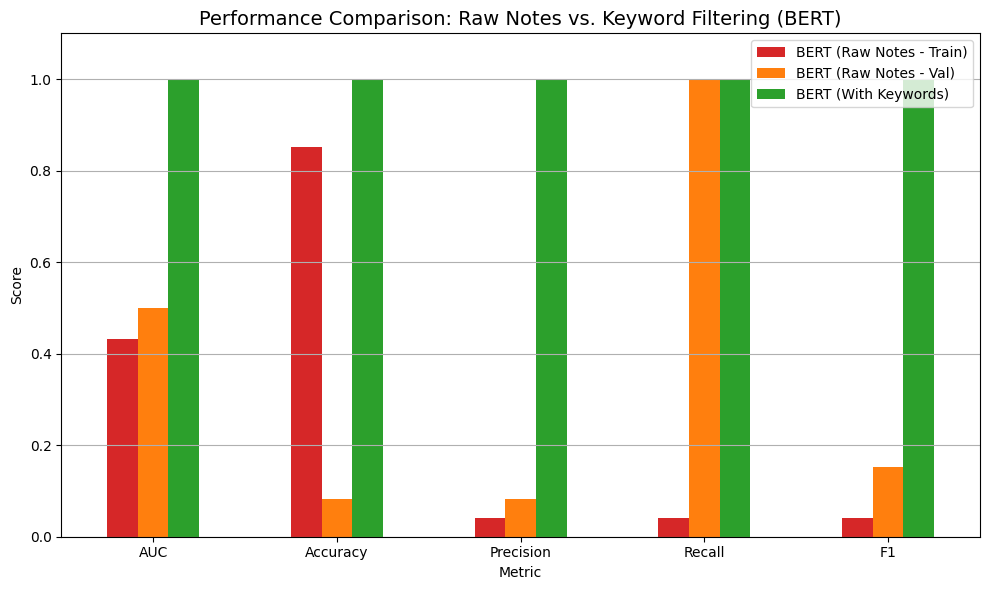

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define full metrics from your logs
metrics_df = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Precision", "Recall", "F1"],
    "BERT (Raw Notes - Train)": [0.4312, 0.8513, 0.0417, 0.0417, 0.0417],
    "BERT (Raw Notes - Val)":   [0.5000, 0.0819, 0.0819, 1.0000, 0.1514],
    "BERT (With Keywords)":     [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
})

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.set_index("Metric").plot(kind="bar", ax=ax, color=["#d62728", "#ff7f0e", "#2ca02c"])
ax.set_title("Performance Comparison: Raw Notes vs. Keyword Filtering (BERT)", fontsize=14)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


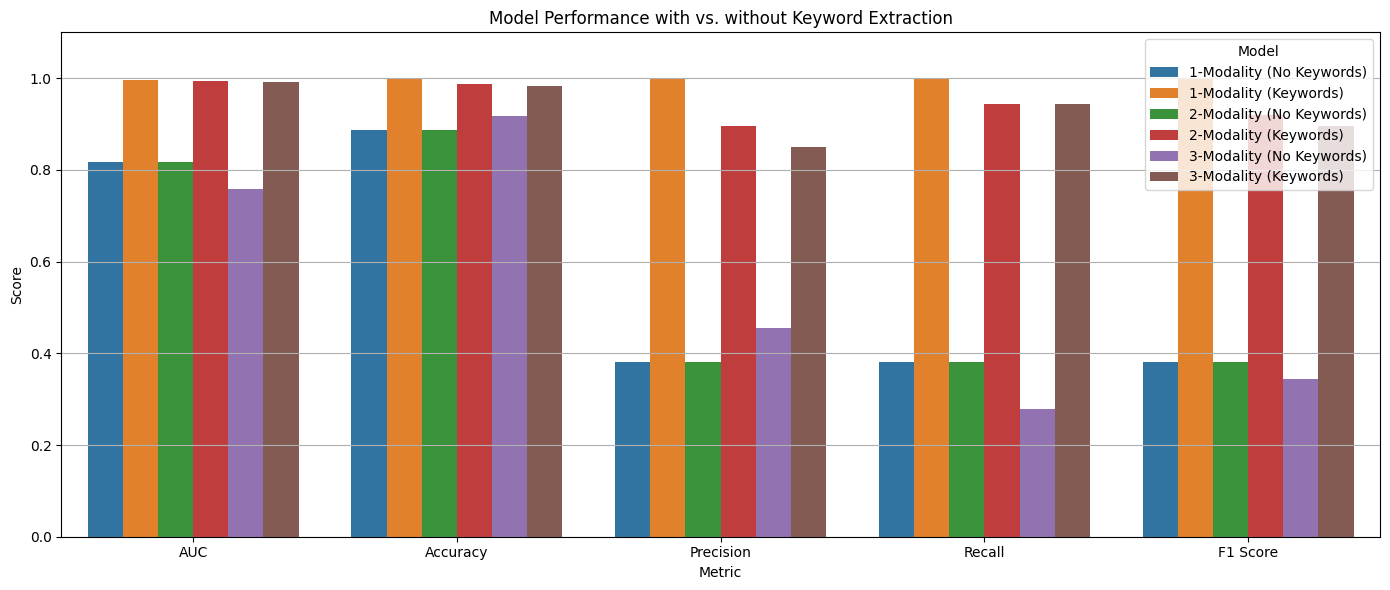

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Updated validation metrics with all six configurations
compare_df = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Precision", "Recall", "F1 Score"],
    "1-Modality (No Keywords)":   [0.8183, 0.8879, 0.3810, 0.3810, 0.3810],
    "1-Modality (Keywords)":      [0.9971, 1.0000, 1.0000, 1.0000, 1.0000],
    "2-Modality (No Keywords)":   [0.8183, 0.8879, 0.3810, 0.3810, 0.3810],
    "2-Modality (Keywords)":      [0.9935, 0.9871, 0.8947, 0.9444, 0.9189],
    "3-Modality (No Keywords)":   [0.7586, 0.9181, 0.4545, 0.2778, 0.3440],
    "3-Modality (Keywords)":      [0.9920, 0.9828, 0.8500, 0.9444, 0.8947]
})

# Reshape for seaborn
melted_df = compare_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model")
plt.title("Model Performance with vs. without Keyword Extraction")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


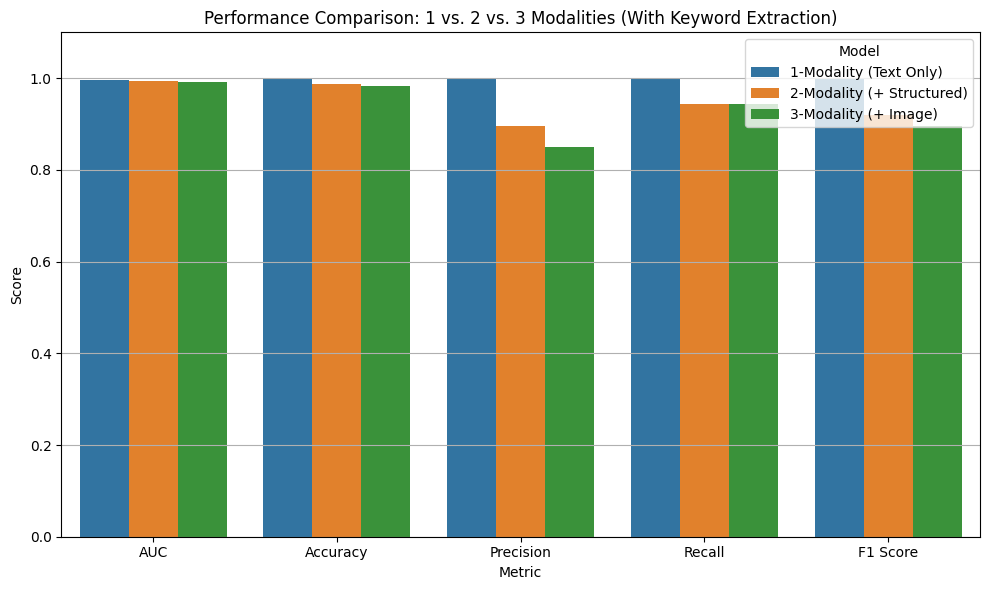

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data: only models with keyword extraction
compare_df = pd.DataFrame({
    "Metric": ["AUC", "Accuracy", "Precision", "Recall", "F1 Score"],
    "1-Modality (Text Only)":      [0.9971, 1.0000, 1.0000, 1.0000, 1.0000],
    "2-Modality (+ Structured)":   [0.9935, 0.9871, 0.8947, 0.9444, 0.9189],
    "3-Modality (+ Image)":        [0.9920, 0.9828, 0.8500, 0.9444, 0.8947]
})

# Reshape for seaborn
melted_df = compare_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model")
plt.title("Performance Comparison: 1 vs. 2 vs. 3 Modalities (With Keyword Extraction)")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
